# Import unwrap

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap

  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-b1n7_zkw
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-b1n7_zkw
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13504 sha256=d2a731fdc2a2e49522b45a3a7c4495f5fa6cf93b5e150ebdd9970ccac29a271c
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-gmb8jhuv/wheels/47/bc/53/d9d6125a8e23f45962719159f75463c156228288997ba3313f
Successfully built unwrap


# Read in data

In [ ]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


# Plot data

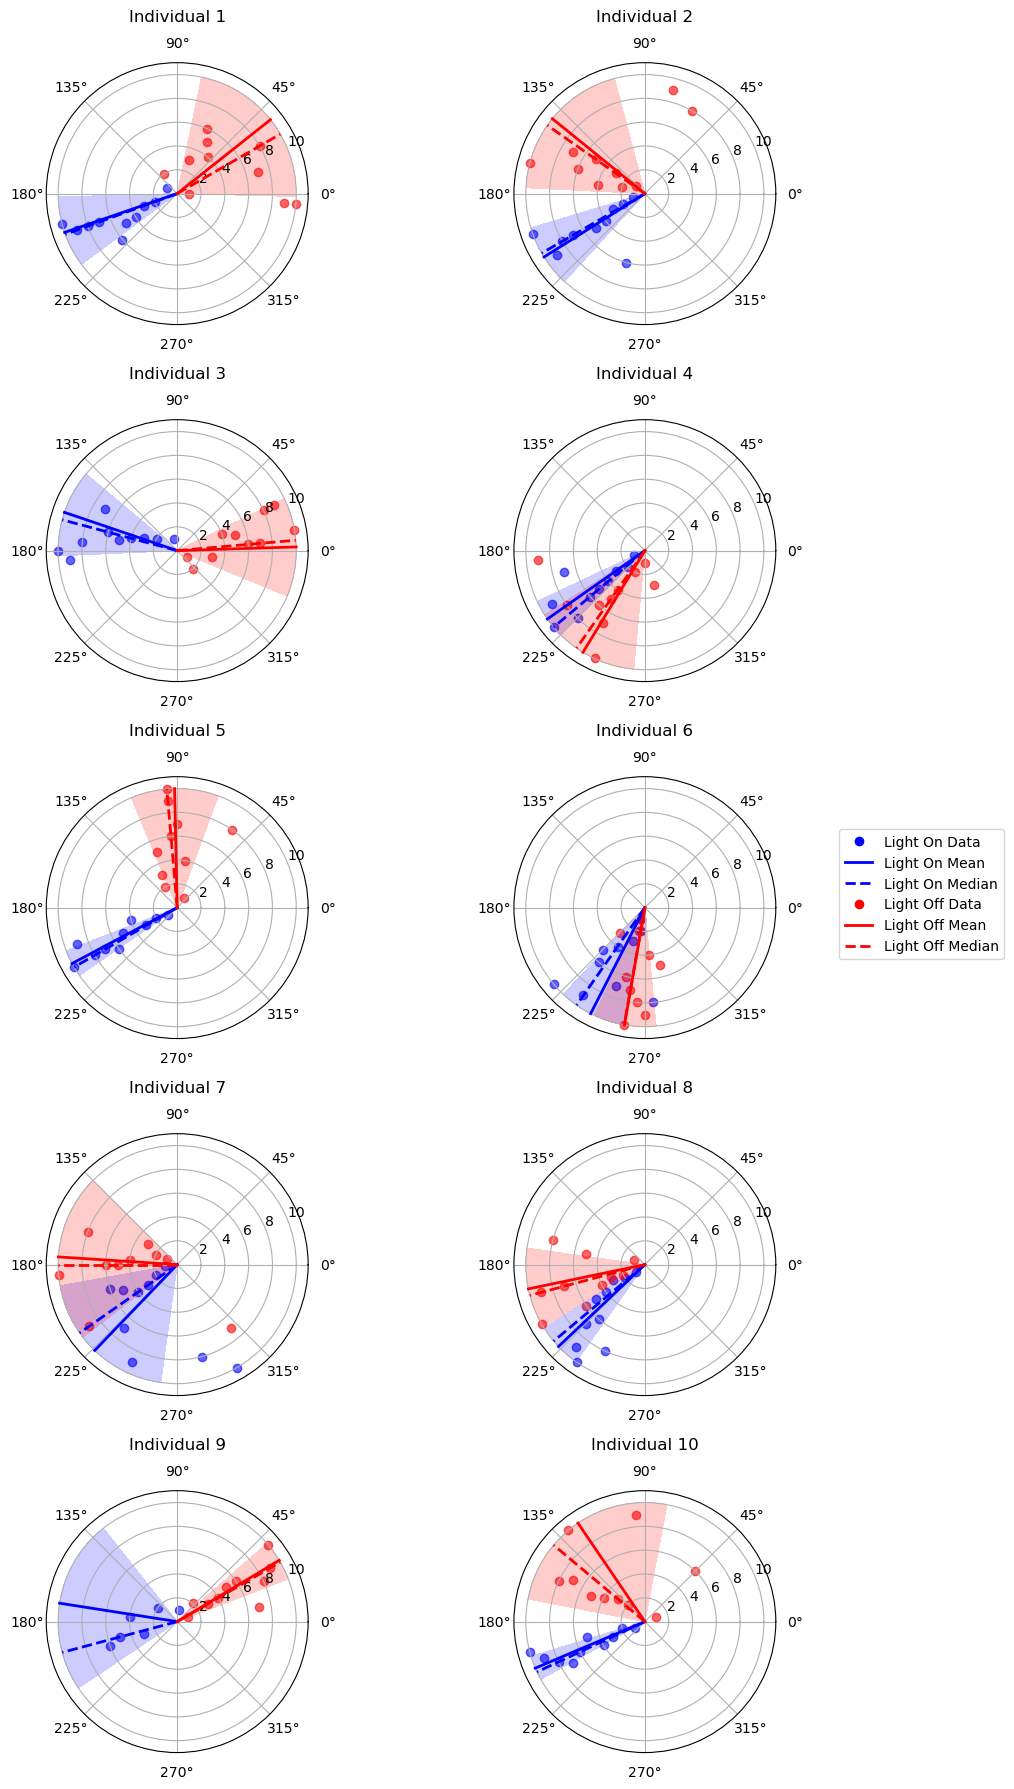

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Initial model

In [ ]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "Light|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_tight = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_tight)

# Fit the model.
idata_tight = model_tight.fit(draws=1000)


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_sigma, Light|Individual_offset, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


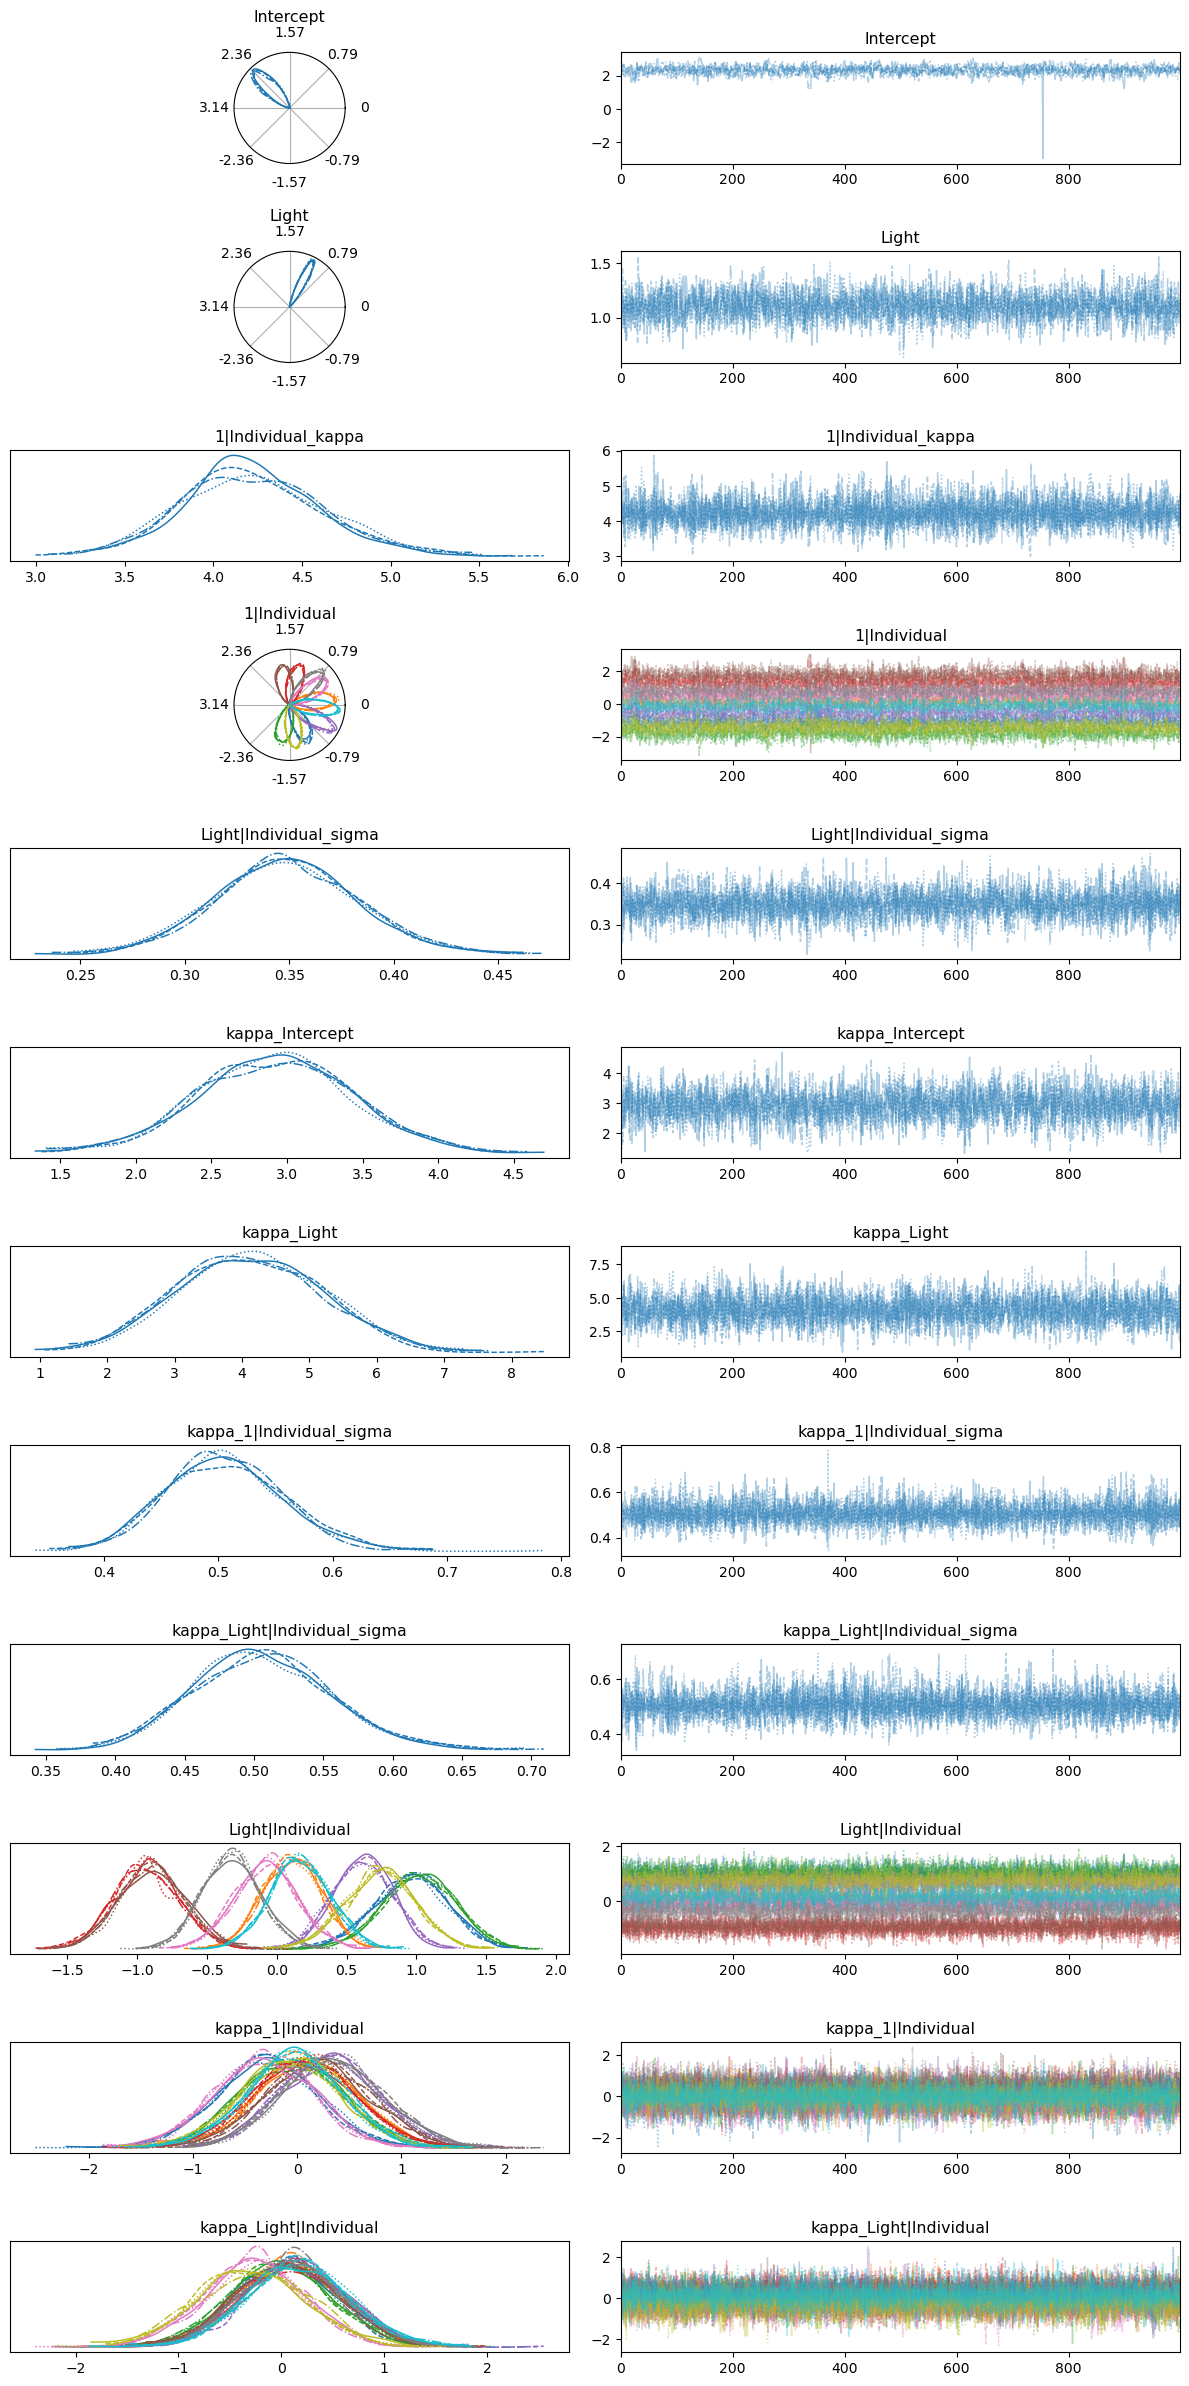

In [ ]:
az.plot_trace(idata_tight, circ_var_names=["Light", "Intercept", "1|Individual"])
plt.tight_layout()
plt.show()

In [ ]:
az.summary(
    idata_tight, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        2.328  0.249   1.849    2.772      0.006    0.014    1255.0   
Light            1.107  0.127   0.867    1.341      0.003    0.002    3691.0   
kappa_Intercept  2.923  0.509   2.025    3.953      0.010    0.008    2873.0   
kappa_Light      4.116  1.064   2.240    6.154      0.016    0.014    4574.0   

                 ess_tail  r_hat  
Intercept          1768.0    1.0  
Light              3145.0    1.0  
kappa_Intercept    2478.0    1.0  
kappa_Light        3319.0    1.0

In [ ]:
az.summary(
    idata_tight, 
    circ_var_names=["Intercept", "Light", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.328  0.249   1.849    2.772      0.006   
Light                         1.107  0.127   0.867    1.341      0.003   
1|Individual_kappa            4.224  0.396   3.503    4.999      0.005   
1|Individual[1]              -1.044  0.322  -1.615   -0.412      0.009   
1|Individual[2]               0.143  0.278  -0.378    0.641      0.005   
1|Individual[3]              -1.773  0.337  -2.406   -1.132      0.007   
1|Individual[4]               1.362  0.326   0.772    1.997      0.006   
1|Individual[5]              -0.492  0.274  -1.054   -0.000      0.009   
1|Individual[6]               1.803  0.330   1.211    2.436      0.005   
1|Individual[7]               0.601  0.294   0.067    1.167      0.005   
1|Individual[8]               0.827  0.284   0.314    1.364      0.007   
1|Individual[9]              -1.401  0.308  -1.994   -0.839      0.007   
1|Individual[10]             -0.079  0.277  -0.600    0.446      0.006   
Light|Individual_sigma        0.349  0.034   0.284    0.414      0.001   
kappa_Intercept               2.923  0.509   2.025    3.953      0.010   
kappa_Light                   4.116  1.064   2.240    6.154      0.016   
kappa_1|Individual_sigma      0.506  0.052   0.407    0.601      0.001   
kappa_Light|Individual_sigma  0.507  0.050   0.417    0.604      0.001   
Light|Individual[1]           0.957  0.268   0.465    1.473      0.004   
Light|Individual[2]           0.111  0.209  -0.265    0.507      0.003   
Light|Individual[3]           1.020  0.259   0.545    1.513      0.004   
Light|Individual[4]          -0.930  0.239  -1.349   -0.456      0.003   
Light|Individual[5]           0.616  0.213   0.214    1.001      0.003   
Light|Individual[6]          -0.888  0.235  -1.329   -0.445      0.004   
Light|Individual[7]          -0.075  0.225  -0.480    0.370      0.003   
Light|Individual[8]          -0.325  0.205  -0.698    0.073      0.003   
Light|Individual[9]           0.742  0.250   0.273    1.210      0.004   
Light|Individual[10]          0.167  0.213  -0.223    0.578      0.003   
kappa_1|Individual[1]        -0.290  0.503  -1.237    0.652      0.006   
kappa_1|Individual[2]         0.093  0.482  -0.819    1.001      0.006   
kappa_1|Individual[3]        -0.055  0.499  -0.906    0.945      0.006   
kappa_1|Individual[4]         0.071  0.493  -0.844    0.999      0.006   
kappa_1|Individual[5]         0.313  0.477  -0.525    1.252      0.005   
kappa_1|Individual[6]         0.198  0.505  -0.702    1.164      0.006   
kappa_1|Individual[7]        -0.320  0.475  -1.225    0.552      0.006   
kappa_1|Individual[8]         0.337  0.486  -0.538    1.279      0.006   
kappa_1|Individual[9]        -0.060  0.485  -1.022    0.812      0.006   
kappa_1|Individual[10]       -0.027  0.467  -0.932    0.852      0.005   
kappa_Light|Individual[1]     0.056  0.495  -0.848    1.001      0.005   
kappa_Light|Individual[2]     0.088  0.503  -0.904    1.006      0.005   
kappa_Light|Individual[3]    -0.012  0.503  -0.944    0.937      0.005   
kappa_Light|Individual[4]     0.112  0.506  -0.840    1.044      0.006   
kappa_Light|Individual[5]     0.134  0.492  -0.776    1.048      0.005   
kappa_Light|Individual[6]     0.054  0.503  -0.863    1.012      0.006   
kappa_Light|Individual[7]    -0.267  0.493  -1.186    0.665      0.006   
kappa_Light|Individual[8]     0.110  0.493  -0.795    1.035      0.005   
kappa_Light|Individual[9]    -0.291  0.527  -1.248    0.710      0.006   
kappa_Light|Individual[10]    0.170  0.508  -0.751    1.140      0.005   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.014    1255.0    1768.0    1.0  
Light                           0.002    3691.0    3145.0    1.0  
1|Individual_kappa              0.007    6830.0    2749.0    1.0  
1|Individual[1]                 0.005    1907.0    2511.0    1.0  
1|Individual[2]                 0.005    1453.0    2071.0    1.0  
1|

## Plot intitial model

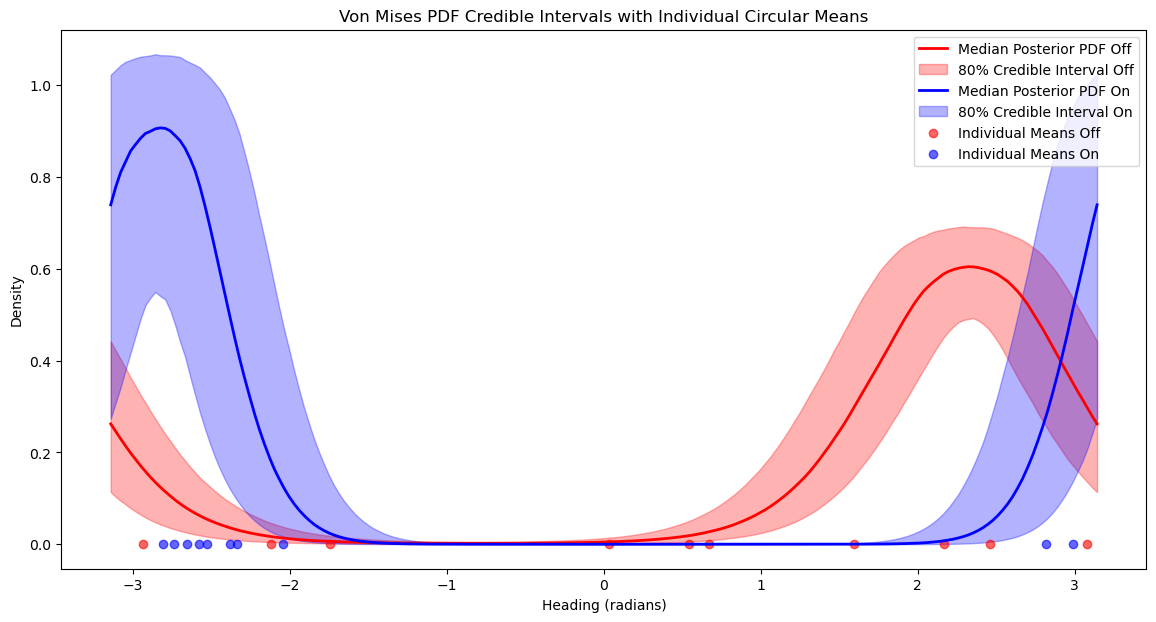

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_tight.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_tight.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_tight.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_tight.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


## Plot population-level predictions

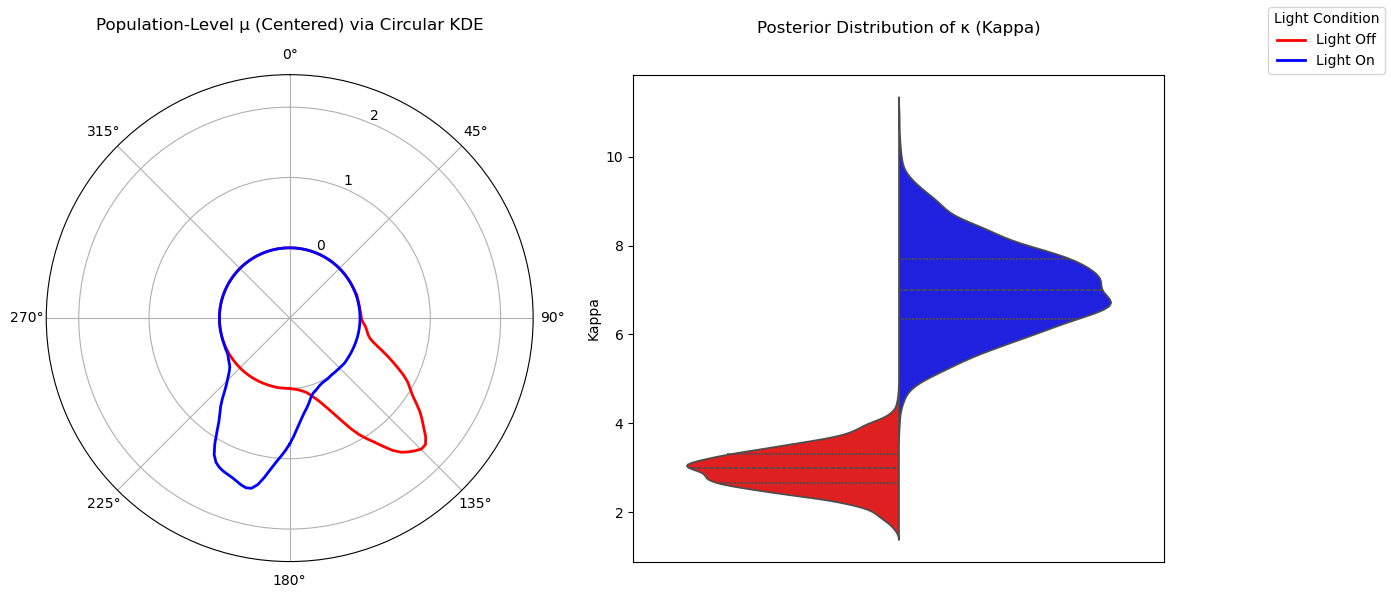

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 2, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for Both Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()


# Model with larger treatment effect on hyperparameters
Did I actually want to change anything here?

In [ ]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_wide = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_wide= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    # "Light": bmb.Prior("Normal", mu=0, sigma= 0.75 * np.pi),#wider
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251021 proposed shrinkage prior
    ),
    "Light|Individual": bmb.Prior(
        # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # my assumed potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=3),#wider possible range
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#slightly wider
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=3.0)#much wider
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_wide = bmb.Model(
    formula_wide,
    df,
    family="vonmises",
    priors=priors_wide,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_wide)

# Fit the model.
idata_wide = model_wide.fit(draws=1000)


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 3.0))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 1.0))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


## Inspect summary


In [ ]:
az.summary(
    idata_wide, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.298  0.483   1.438   -3.050      0.012   
Light                         1.282  0.292   0.741    1.827      0.009   
kappa_Intercept               4.804  1.037   3.045    6.887      0.023   
kappa_Light                   4.309  2.052   0.215    7.844      0.042   
1|Individual_kappa            1.848  0.472   1.000    2.709      0.006   
Light|Individual_kappa        2.732  0.753   1.456    4.221      0.013   
kappa_1|Individual_sigma      2.292  1.183   0.001    4.251      0.035   
kappa_Light|Individual_sigma  7.542  4.354   1.118   15.760      0.132   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.071     950.0    1023.0   1.00  
Light                           0.008     617.0    1066.0   1.01  
kappa_Intercept                 0.020    2205.0    2290.0   1.00  
kappa_Light                     0.033    2413.0    2252.0   1.00  
1|Individual_kappa              0.009    5904.0    2349.0   1.00  
Light|Individual_kappa          0.015    3318.0    2215.0   1.00  
kappa_1|Individual_sigma        0.023     975.0     807.0   1.00  
kappa_Light|Individual_sigma    0.142    1021.0    1165.0   1.00

In [ ]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual", "kappa_Light|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]             -1.430  0.540  -2.392   -0.396      0.015   
1|Individual[2]              0.151  0.492  -0.737    1.099      0.012   
1|Individual[3]             -2.172  0.518  -3.107   -1.209      0.013   
1|Individual[4]              1.770  0.511   0.861    2.761      0.014   
1|Individual[5]             -0.656  0.489  -1.525    0.291      0.014   
1|Individual[6]              2.172  0.508   1.243    3.133      0.013   
1|Individual[7]              0.689  0.507  -0.320    1.595      0.011   
1|Individual[8]              0.994  0.493   0.086    1.912      0.014   
1|Individual[9]             -1.694  0.503  -2.653   -0.806      0.012   
1|Individual[10]            -0.113  0.492  -1.023    0.815      0.011   
Light|Individual[1]          1.298  0.391   0.537    2.008      0.011   
Light|Individual[2]         -0.029  0.328  -0.654    0.570      0.010   
Light|Individual[3]          1.370  0.355   0.718    2.047      0.010   
Light|Individual[4]         -1.580  0.345  -2.197   -0.923      0.010   
Light|Individual[5]          0.696  0.320   0.075    1.258      0.009   
Light|Individual[6]         -1.489  0.334  -2.134   -0.875      0.010   
Light|Individual[7]         -0.291  0.378  -1.052    0.374      0.005   
Light|Individual[8]         -0.664  0.324  -1.272   -0.071      0.010   
Light|Individual[9]          0.835  0.490  -0.139    1.724      0.017   
Light|Individual[10]         0.073  0.340  -0.525    0.732      0.008   
kappa_1|Individual[1]       -1.643  1.565  -4.846    0.798      0.040   
kappa_1|Individual[2]       -1.005  1.469  -3.836    1.698      0.029   
kappa_1|Individual[3]        0.335  1.643  -2.700    3.733      0.027   
kappa_1|Individual[4]        0.554  1.663  -2.570    3.943      0.026   
kappa_1|Individual[5]        1.521  1.893  -1.722    5.281      0.035   
kappa_1|Individual[6]        1.989  2.160  -1.503    6.250      0.043   
kappa_1|Individual[7]       -1.856  1.460  -4.524    0.674      0.032   
kappa_1|Individual[8]        1.587  1.997  -1.856    5.418      0.035   
kappa_1|Individual[9]        1.762  2.219  -1.792    6.034      0.052   
kappa_1|Individual[10]      -1.786  1.464  -4.826    0.533      0.034   
kappa_Light|Individual[1]    2.862  4.239  -4.129   11.478      0.079   
kappa_Light|Individual[2]    3.875  4.632  -3.926   12.944      0.088   
kappa_Light|Individual[3]   -0.943  3.651  -7.989    5.975      0.063   
kappa_Light|Individual[4]    7.712  7.012  -2.992   21.219      0.166   
kappa_Light|Individual[5]    9.747  8.962  -3.023   26.793      0.224   
kappa_Light|Individual[6]    1.453  4.576  -6.803   10.147      0.076   
kappa_Light|Individual[7]   -3.663  2.619  -9.001    0.789      0.051   
kappa_Light|Individual[8]    5.886  6.385  -4.203   18.395      0.139   
kappa_Light|Individual[9]   -8.824  4.820 -16.255   -0.217      0.129   
kappa_Light|Individual[10]  11.672  9.398  -1.472   28.989      0.247   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]               0.019     726.0    1188.0   1.00  
1|Individual[2]               0.011     630.0    1103.0   1.00  
1|Individual[3]               0.061     985.0    1312.0   1.00  
1|Individual[4]               0.037     689.0    1226.0   1.00  
1|Individual[5]               0.012     607.0    1039.0   1.00  
1|Individual[6]               0.058     873.0    1304.0   1.00  
1|Individual[7]               0.011     678.0    1168.0   1.00  
1|Individual[8]               0.012     613.0    1081.0   1.00  
1|Individual[9]               0.039     661.0    1235.0   1.00  
1|Individual[10]              0.011     682.0    1046.0   1.00  
Light|Individual[1]           0.009     948.0    1635.0   1.00  
Light|Individual[2]           0.008     884.0    1669.0   1.00  
Light|Individual[3]           0.008     803.0    1324.0   1.00  
Light|Individual[4]           0.008     748.0    1389.0   1.00  
Light|Individual[5]           0.008     723.0    1098.0   1.0

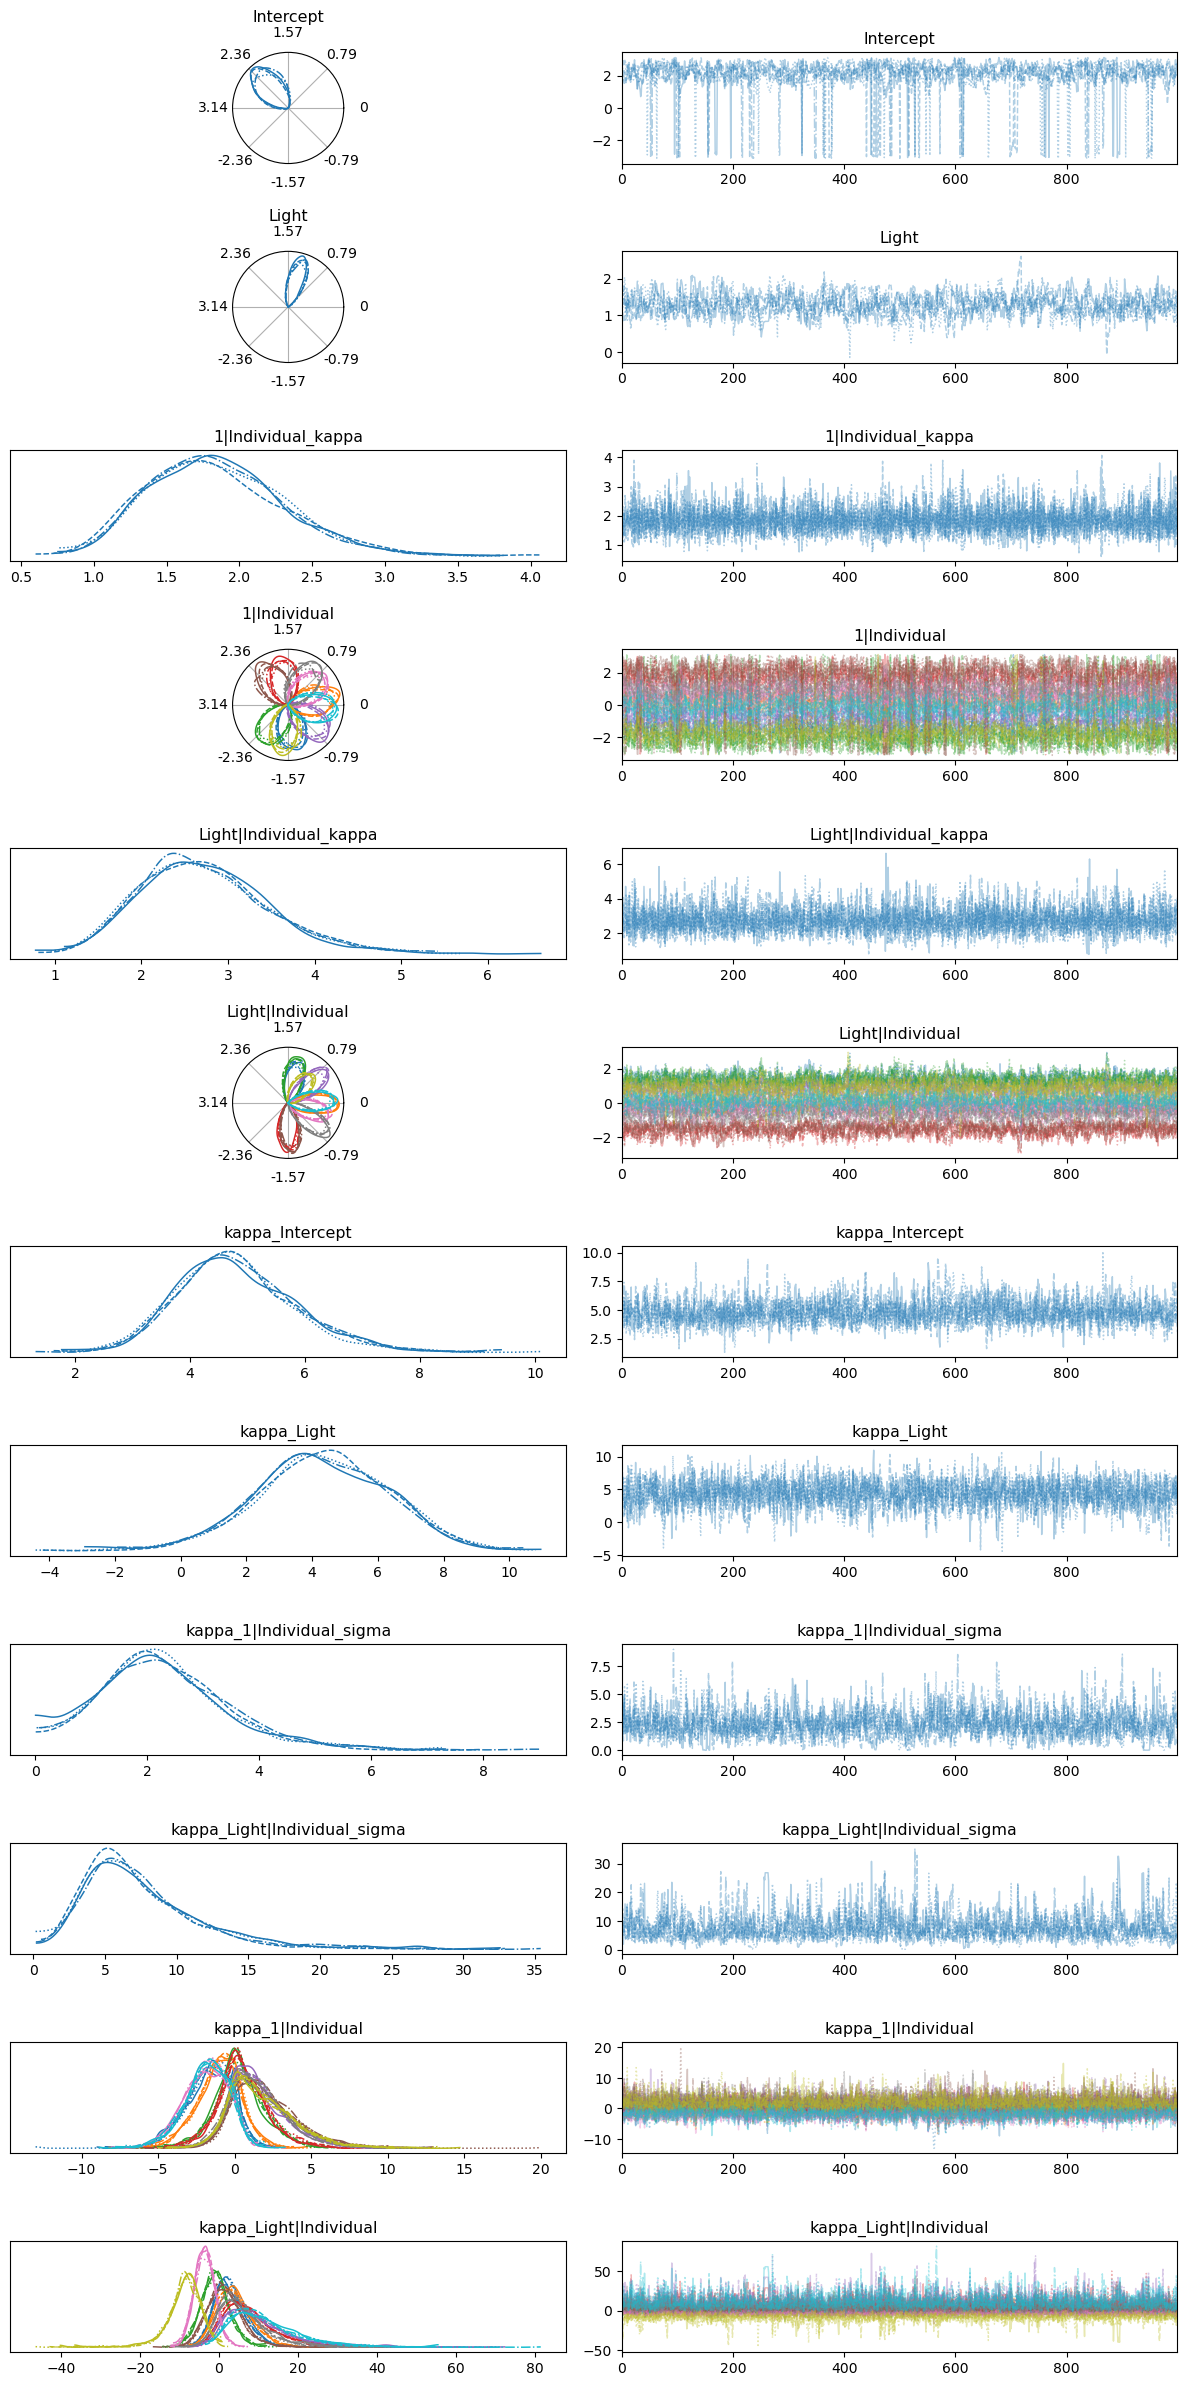

In [ ]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_wide_trans = idata_wide.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_wide,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model comparison for hypothesis testing
Initially, just compare the restrictive and loosened prior models


In [ ]:
#First the log likelihood function needs to be computed for each model and dataset

model_tight.compute_log_likelihood(idata_tight)
model_wide.compute_log_likelihood(idata_wide)



In [ ]:
#Calculate predictive power using LOO cross-validation
import pymc as pm
loo_tight = az.loo(idata_tight)
loo_wide = az.loo(idata_wide)
# loo_wide = az.reloo(loo_orig=loo_wide,
#                     wrapper=az.SamplingWrapper(model_wide),
#                     k_thresh = 0.7)

/opt/miniconda3/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


TypeError: Passed wrapper instance does not implement all methods required for reloo to work. Check the documentation of SamplingWrapper. ['sel_observations', 'sample', 'get_inference_data', 'log_likelihood__i'] must be implemented and were not found.

In [ ]:
#print the results
print('\n----- Tight -----\n')
print(loo_tight)
print('\n----- Wide -----\n')
print(loo_wide)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'Tight':loo_tight,
            'Wide':loo_wide,
            }, 
            ic="loo")


----- Tight -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -154.36    13.99
p_loo       22.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      196  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


----- Wide -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -122.56    16.40
p_loo       37.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      189   96.4%
   (0.70, 1]   (bad)         5    2.6%
   (1, Inf)   (very bad)    2    1.0%



rank    elpd_loo      p_loo  elpd_diff    weight         se       dse  \
Wide      0 -122.558463  37.550777    0.00000  0.945595  16.404649  0.000000   
Tight     1 -154.359673  22.110915   31.80121  0.054405  13.994971  7.442225   

       warning scale  
Wide      True   log  
Tight    False   log